## **Car Price Prediction Using Linear, Polynomial, and Tree-Based Regressors**

In this notebook, we aim to predict car prices using these traditional regression models:

&nbsp;&nbsp;&nbsp;&nbsp;⚡ *Linear Regression*  
&nbsp;&nbsp;&nbsp;&nbsp;⚡ *Linear Regression with L1 (Lasso) Regularization*  
&nbsp;&nbsp;&nbsp;&nbsp;⚡ *Linear Regression with L2 (Ridge) Regularization*  
&nbsp;&nbsp;&nbsp;&nbsp;⚡ *2nd and 3rd-Deg. Polynomial Transformations (Ridge Regularized)*  
&nbsp;&nbsp;&nbsp;&nbsp;⚡ *Decision Tree Regression*  

The workflow is divided into three main sections:

&nbsp;&nbsp;&nbsp;&nbsp;✅ *Exploratory Data Analysis (EDA)*
&nbsp;&nbsp;&nbsp;&nbsp;✅ *Data Preprocessing*
&nbsp;&nbsp;&nbsp;&nbsp;✅ *Model Fitting*

After performing exploratory data analysis (EDA) to understand key trends and relationships in the dataset, we proceed with preprocessing the features before training the models. The model performances are evaluated using: **Mean Squared Error (MSE)** and **R²** on training, validation, and test datasets.

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from scipy.stats import chi2_contingency, chi2

import warnings
warnings.filterwarnings('ignore')

## **1. Exploratory Data Analysis (EDA)**

### **1.1 Load and Inspect the Dataset**

In [2]:
# Initialize dataset
df = pd.read_csv('/kaggle/input/cardataset/data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
# Display basic dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_fuel_type   11911 non-null  object 
 4   engine_hp          11845 non-null  float64
 5   engine_cylinders   11884 non-null  float64
 6   transmission_type  11914 non-null  object 
 7   driven_wheels      11914 non-null  object 
 8   number_of_doors    11908 non-null  float64
 9   market_category    8172 non-null   object 
 10  vehicle_size       11914 non-null  object 
 11  vehicle_style      11914 non-null  object 
 12  highway_mpg        11914 non-null  int64  
 13  city_mpg           11914 non-null  int64  
 14  popularity         11914 non-null  int64  
 15  msrp               11914 non-null  int64  
dtypes: float64(3), int64(5

In [4]:
# Summary stats for numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,11914.0,2010.384338,7.579740,1990.0,2007.0,2015.0,2016.00,2017.0
engine_hp,11845.0,249.386070,109.191870,55.0,170.0,227.0,300.00,1001.0
engine_cylinders,11884.0,5.628829,1.780559,0.0,4.0,6.0,6.00,16.0
number_of_doors,11908.0,3.436093,0.881315,2.0,2.0,4.0,4.00,4.0
highway_mpg,11914.0,26.637485,8.863001,12.0,22.0,26.0,30.00,354.0
city_mpg,11914.0,19.733255,8.987798,7.0,16.0,18.0,22.00,137.0
popularity,11914.0,1554.911197,1441.855347,2.0,549.0,1385.0,2009.00,5657.0
msrp,11914.0,40594.737032,60109.103604,2000.0,21000.0,29995.0,42231.25,2065902.0


### **1.2 See Target Distribution and Normalize if Needed**

We examine the distribution of the target `msrp` to check for skewness. Car prices usually form a right-skewed distribution, which can negatively impact performance, especially with linear models. If we see strong skewness, we apply log transformation to normalize the target, making it more suitable for regression modeling.

In [5]:
fig1 = px.histogram(df, x="msrp", nbins=50, title="MSRP Distribution")
fig1.show(renderer='iframe')

**Takeways:**

- The target distribution shows significant right-skewness.
- Majority of vehicles are concentrated in a single dominant bin at the lower end.
- The right tail stretches, with some high-priced outliers likely representing exotic vehicles.
- Distribution deviates considerably from normality. We will apply log transformation.

In [6]:
# Reduce target skewness with log transformation.
df['msrp_log'] = np.log1p(df['msrp'])  
fig2 = px.histogram(df, x="msrp_log", nbins=50, title="Log MSRP Distribution")
fig2.show(renderer='iframe')

### **1.3 Look for Trends and Polynomial Shapes**

We explore how each numerical feature relates to the target variable `msrp_log`. By fitting both linear and polynomial (deg. 2 and 3) regression curves, we can visually assess whether a simple linear model is enough or if higher-order relationships exist. This helps guide feature engineering and model selection. We essentially identify potential non-linear trends that regular linear regression may not capture.

In [7]:
# Extract the numerical features for the next series of visualizations
df_nums = df.select_dtypes(include="number")
df_nums.head()

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,msrp,msrp_log
0,2011,335.0,6.0,2.0,26,19,3916,46135,10.739349
1,2011,300.0,6.0,2.0,28,19,3916,40650,10.612779
2,2011,300.0,6.0,2.0,28,20,3916,36350,10.500977
3,2011,230.0,6.0,2.0,28,18,3916,29450,10.290483
4,2011,230.0,6.0,2.0,28,18,3916,34500,10.448744


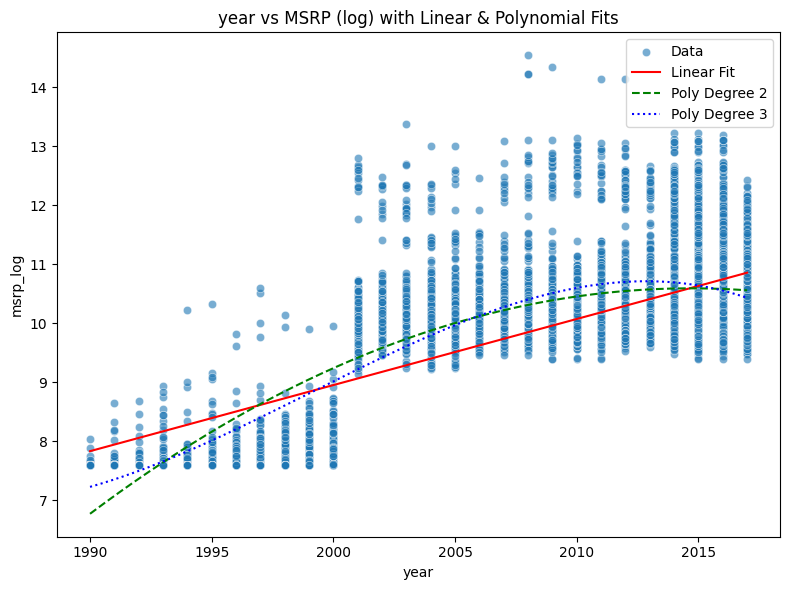

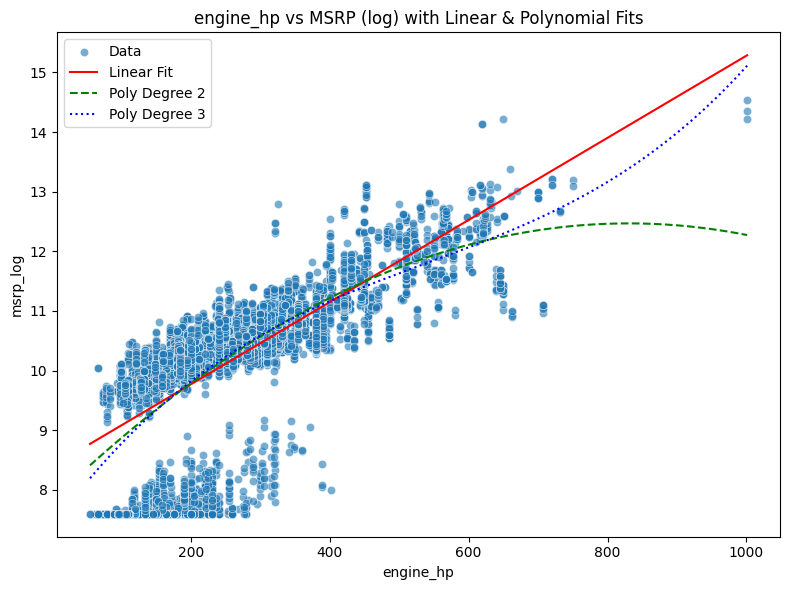

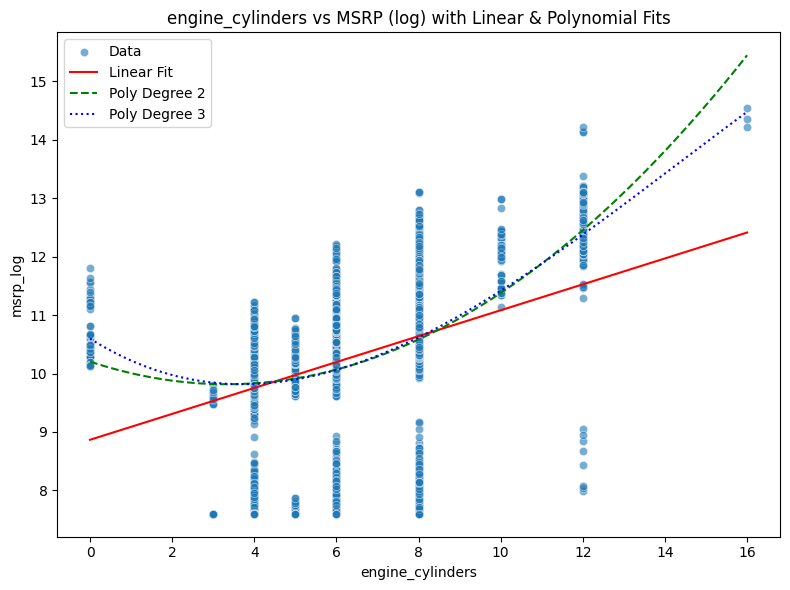

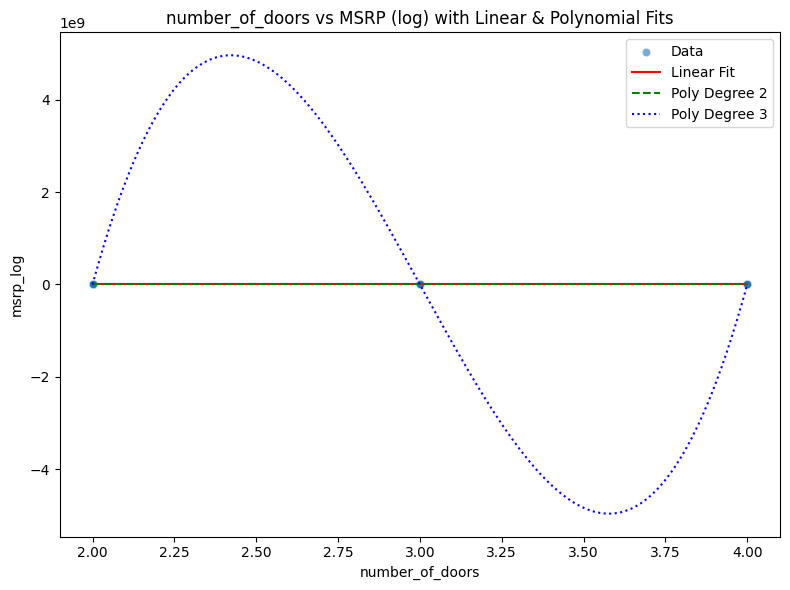

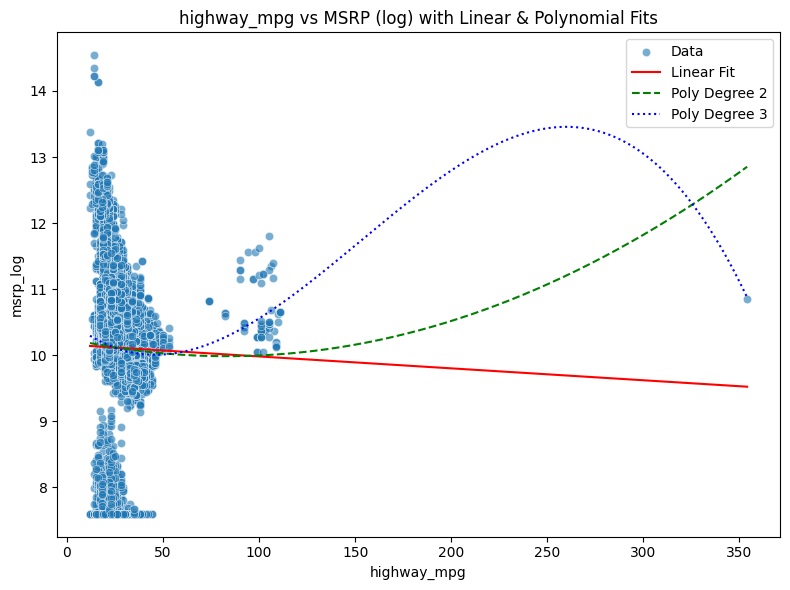

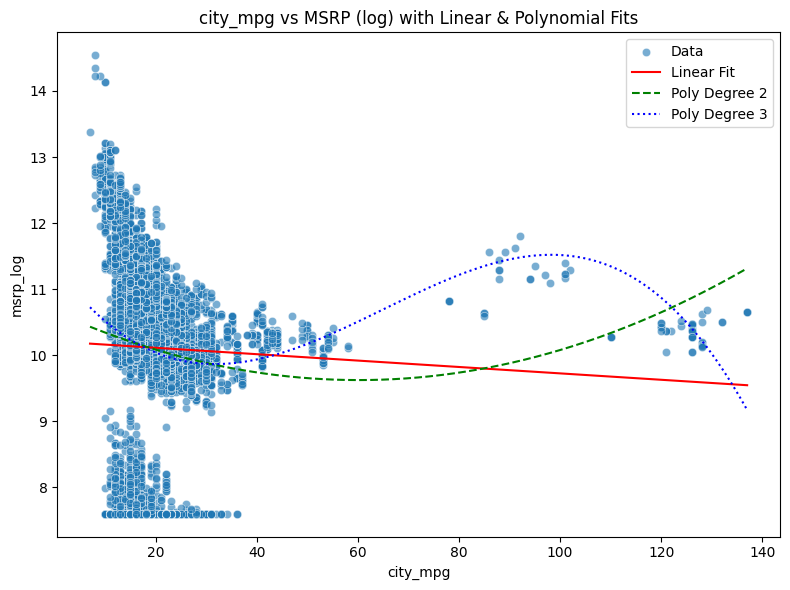

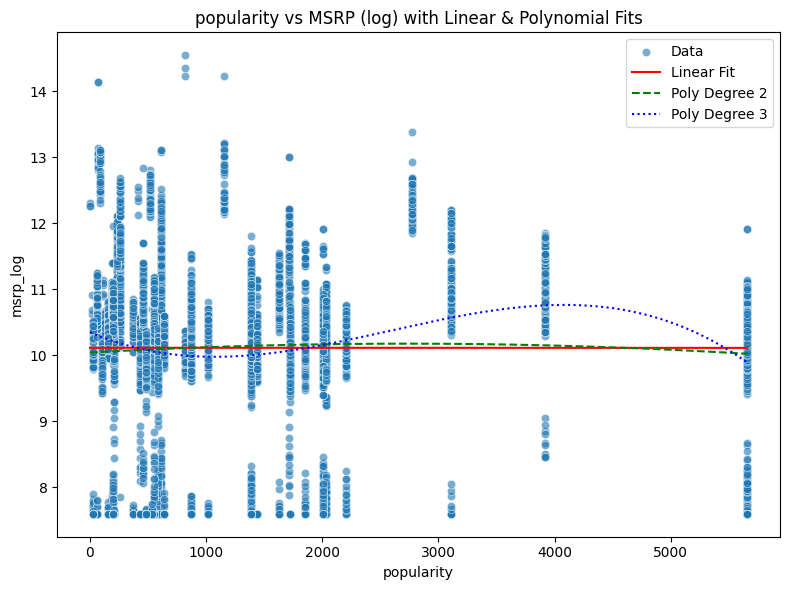

In [8]:
# Loop through each numerical feature to visualize its relationship with 'msrp_log'

for column in df_nums.columns[:-2]:
    # Clean data by dropping NA values for the current feature and target
    df_sub = df_nums[[column, "msrp_log"]].dropna()
    X = df_sub[[column]].values
    y = df_sub["msrp_log"].values

    # Create a smooth x-value range for plotting regression curves
    x_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)

    # Fit and predict using a simple linear regression model
    lin_reg = LinearRegression().fit(X, y)
    y_lin_pred = lin_reg.predict(x_range)

    # Fit and predict using degree-2 polynomial regression
    poly2 = PolynomialFeatures(degree=2)
    X_poly2 = poly2.fit_transform(X)
    lin_reg2 = LinearRegression().fit(X_poly2, y)
    y_poly2_pred = lin_reg2.predict(poly2.transform(x_range))

    # Fit and predict using degree-3 polynomial regression
    poly3 = PolynomialFeatures(degree=3)
    X_poly3 = poly3.fit_transform(X)
    lin_reg3 = LinearRegression().fit(X_poly3, y)
    y_poly3_pred = lin_reg3.predict(poly3.transform(x_range))

    # Plot the scatter plot and overlay linear and polynomial regression curves
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X.flatten(), y=y, label="Data", alpha=0.6)
    plt.plot(x_range, y_lin_pred, color="red", label="Linear Fit")
    plt.plot(x_range, y_poly2_pred, color="green", linestyle='--', label="Poly Degree 2")
    plt.plot(x_range, y_poly3_pred, color="blue", linestyle=':', label="Poly Degree 3")

    # Add labels, title, and legends
    plt.xlabel(column)
    plt.ylabel("msrp_log")
    plt.title(f"{column} vs MSRP (log) with Linear & Polynomial Fits")
    plt.legend()
    plt.tight_layout()
    plt.show()

### **1.4 See Correlation Between Numerical Columns**

We can visualize the correlations for all numerical features, including the log-transformed target `msrp_log`. This helps identify multicollinearity between features (look for values approaching 1 or -1 between features). We can see which variables are strongly correlated with the target. When features are strongly correlated, techniques like dimensionality reduction or regularization can help reduce redundancy and improve model performance.

In [9]:
c_table = df_nums.corr()
fig4 = px.imshow(c_table, text_auto=True, color_continuous_scale='RdBu_r', title='Correlation Heatmap', width=800, height=800)
fig4.update_traces(textfont_size=9.5)
fig4.show(renderer='iframe')

**Takeaways:**

- `msrp`/`msrp_log` are closely correlated with`year`,  (cylinder count).
- Age and performance are also key price determinants.
- `engine_hp`, and `engine_cylinders` show a strong positive relationship. More cylinders means more power.
- `engine_hp`, and `engine_cylinders` show a negative relationship with `city_mpg` and `highway_mpg`. Larger engines consume more fuel.

### **1.5 Analyze MSRP Across Vehicle Specs**

We look at how the target `msrp_log` varies across key vehicle specifications like make, vehicle style, engine power, and fuel type. 

By visualizing how prices vary across different features, we can uncover meaningful patterns, detect outliers, and assess which features may influence car pricing.

In [10]:
# Price distribution per vehicle style
fig5 = px.box(df, x="vehicle_style", y="msrp_log", title="Log MSRP Distribution by Vehicle Style")
fig5.show(renderer="iframe")

In [11]:
# How price varies across the top 20 brands
top_makes = df["make"].value_counts().nlargest(20).index
fig6 = px.box(df[df["make"].isin(top_makes)], x="make", y="msrp_log", title="Log MSRP by Top 20 Makes")
fig6.show(renderer="iframe")

In [12]:
# See if smaller cars are more fuel efficient and how that reflects in pricing
fig7 = px.scatter(df, x='city_mpg', y='msrp_log', color='vehicle_size', title='City MPG vs Log MSRP (by Vehicle Size)')
fig7.show(renderer='iframe')

In [13]:
# See how EVs cluster
fig8 = px.scatter(df[df["highway_mpg"] <  150], x='highway_mpg', y='msrp_log', color='engine_fuel_type', title='Highway MPG vs Log MSRP (by Fuel Type)')
fig8.show(renderer='iframe')

In [14]:
fig9 = px.scatter(df, x='engine_hp', y='msrp_log', color='engine_cylinders', title='Engine HP vs MSRP (by Cylinder Count)')
fig9.show(renderer='iframe')

### **1.6 See Missing Counts and Percentages Per Column**

In [15]:
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ["column", "missing_count"]
missing_data['missing_pct'] = (missing_data["missing_count"] / len(df)) * 100
missing_data

fig10 = px.bar(missing_data, x="column", y="missing_pct", title="Percentage of Missing Values per Column",
             labels={"missing_pct": "Percent Missing", "column": "Column"},
             text="missing_pct")
fig10.update_traces(texttemplate="%{text:.1f}%", textposition="outside")
fig10.update_layout(yaxis_range=[0, 100])
fig10.show(renderer="iframe")

In [16]:
# Indicator for missingness in market_category
df["market_category_missing"] = df["market_category"].isnull()

# Boxplot of msrp grouped by missingness
fig11 = px.box(df, x="market_category_missing", y="msrp", title="MSRP Distribution by Market Category Missingnes", 
               labels={"market_category_missing": "Market Category Missing", "msrp": "MSRP"})
fig11.update_xaxes(tickvals=[False, True], ticktext=["Not Missing", "Missing"])
fig11.show(renderer="iframe")

## **2. Data Preprocessing**

### **2.1 Handle Missing Values Through Knowledge-Based Imputations**

Imputation will be guided by external, reliable sources and domain-specific knowledge, rather than statistical inference from the dataset.

As a result, it is not necessary to split the dataset prior to this step.

#### **2.1.1 Handle Missing Values for `engine_fuel_type`** 

In [17]:
# See samples with missing `engine_fuel_type`
df[df["engine_fuel_type"].isna()]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,msrp_log,market_category_missing
11321,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,25,17,481,17199,9.752665,True
11322,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,25,17,481,20199,9.913438,True
11323,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,25,17,481,18499,9.825526,True


In [18]:
# Attach accurate values based on info from sources like edmunds and MotorTrend
df.loc[df["engine_fuel_type"].isna(), 'engine_fuel_type'] = 'regular unleaded'

#### **2.1.2 Handle Missing Values for `engine_hp`** 

<Axes: xlabel='msrp_log', ylabel='Count'>

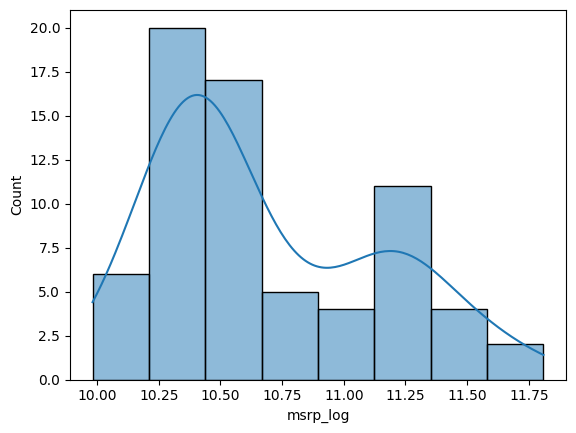

In [19]:
# See msrp_log distribution for samples with missing horsepower values
enhp_na = df[df["engine_hp"].isna()]
sns.histplot(data=enhp_na, x=enhp_na.msrp_log, kde=True)

In [20]:
# Fill missing horsepower values with info from edmunds.com and MotorTrend (part 1)
df.loc[(df["engine_hp"].isna()) & (df["model"] == "500e"), "engine_hp"] = 111
df.loc[(df["engine_hp"].isna()) & (df["model"] == "Continental") & (df["make"] == "Lincoln") & (df["engine_fuel_type"] == "premium unleaded (recommended)") & (df["year"] == 2017), "engine_hp"] = 400
df.loc[(df["engine_hp"].isna()) & (df["model"] == "Continental") & (df["make"] == "Lincoln") & (df["engine_fuel_type"] == "premium unleaded (recommended)") & (df["year"] == 2017), "engine_hp"] = 335
df.loc[(df["engine_hp"].isna()) & (df["model"] == "Escape") & (df["make"] == "Ford") & (df["driven_wheels"] == "front wheel drive") & (df["engine_fuel_type"] == "regular unleaded"), "engine_hp"] = 168
df.loc[(df["engine_hp"].isna()) & (df["model"] == "Escape") & (df["make"] == "Ford") & (df["driven_wheels"] == "all wheel drive") & (df["engine_fuel_type"] == "regular unleaded"), "engine_hp"] = 178
df.loc[(df["engine_hp"].isna()) & (df["model"] == "Fit EV") & (df["make"] == "Honda"), "engine_hp"] = 123
df.loc[(df["engine_hp"].isna()) & (df["model"] == "Focus") & (df["make"] == "Ford") & (df["engine_fuel_type"] == "electric"), "engine_hp"] = 143
df.loc[(df["engine_hp"].isna()) & (df["model"] == "Freestar") & (df["make"] == "Ford") & (df["year"] == 2005), "engine_hp"] = 193
df.loc[(df["engine_hp"].isna()) & (df["model"] == "i-MiEV") & (df["year"] == 2014), "engine_hp"] = 66
df.loc[(df["engine_hp"].isna()) & (df["model"] == "Impala") & (df["make"] == "Chevrolet") & (df["engine_fuel_type"] == "flex-fuel (unleaded/natural gas)"), "engine_hp"] = 260
df.loc[(df["engine_hp"].isna()) & (df["model"] == "Leaf") & (df["make"] == "Nissan"), "engine_hp"] = 107
df.loc[(df["engine_hp"].isna()) & (df["model"] == "M-Class") & (df["make"] == "Mercedes-Benz") & (df["year"] == 2015) & (df["engine_fuel_type"] == "diesel"), "engine_hp"] = 254
df.loc[(df["engine_hp"].isna()) & (df["model"] == "MKZ") & (df["make"] == "Lincoln") & (df["year"] == 2017) & (df["engine_fuel_type"] == "regular unleaded"), "engine_hp"] = 245
df.loc[(df["engine_hp"].isna()) & (df["model"] == "RAV4 EV") & (df["make"] == "Toyota") & (df["year"].isin([2013, 2014])), "engine_hp"] = 154
df.loc[(df["model"] == "Soul EV") & (df["make"] == "Kia"), 'engine_hp'] = 109

In [21]:
# Fill missing horsepower values using publicly available info (part 2)
df.loc[6921, 'engine_hp'] = 362
df.loc[6924, 'engine_hp'] = 422
df.loc[6923, 'engine_hp'] = 691
df.loc[[6922, 6925], 'engine_hp'] = 380
df.loc[6926, 'engine_hp'] = 328
df.loc[6927, 'engine_hp'] = 417
df.loc[6928, 'engine_hp'] = 762
df.loc[6929, 'engine_hp'] = 373
df.loc[6930, 'engine_hp'] = 328
df.loc[6931, 'engine_hp'] = 315
df.loc[6932, 'engine_hp'] = 463
df.loc[6933, 'engine_hp'] = 315
df.loc[6934, 'engine_hp'] = 328
df.loc[6935, ['model', 'engine_hp']] = [2015, 328]
df.loc[6936, ['city_mpg', 'highway_mpg', 'engine_hp']] = [95, 106, 417]
df.loc[6937, ['city_mpg', 'highway_mpg', 'engine_hp']] = [89, 98, 463]
df.loc[6938, 'engine_hp'] = 373

#### **2.1.3 Handle Missing Values for `engine_cylinders`** 

In [22]:
# See models with missing `engine_cylinder` values 
# and check if they are EVs or has a rotary engine
df[df["engine_cylinders"].isna()].model.value_counts()

model
RX-8       17
e-Golf      4
i-MiEV      3
RX-7        3
Bolt EV     2
RAV4 EV     1
Name: count, dtype: int64

**Note:** We can see that all the models with missing `engine_cylinders` values are EVs except for the two Mazda sportcars (RX-7 and RX-8) with rotary engines. Since all of these models don't have traditional cylinders, we will fill the NaN values with 0 (which is the category for 0 cylinders).

In [23]:
# Set missing engine_cylinder to 0
df.loc[df["engine_cylinders"].isna(), "engine_cylinders"] = 0

#### **2.1.4 Handle Missing Values for `number_of_doors`** 

<Axes: xlabel='msrp_log', ylabel='Count'>

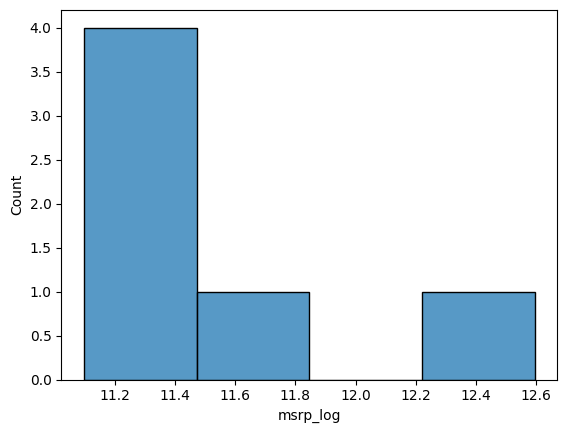

In [24]:
# See msrp_log distribution for samples with missing number_of_doors
ndoors_na = df[df["number_of_doors"].isna()]
sns.histplot(data=ndoors_na, x=ndoors_na.msrp_log)

In [25]:
# Impute missing values based on publicly available info
df.loc[4666, 'number_of_doors'] = 2
df.loc[(df["number_of_doors"].isna()) & (df["model"] == "Model S") & (df["year"] == 2016), 'number_of_doors'] = 4

**Note:** The only remaining variable with missing values is `market_category`. Because of its multi-label nature, imputing this feature is not as straightforward as referring to an online source. Instead, it may involve data-driven inference based on vehicle_style and other features.

### **2.2 Split the Dataset**

To prevent potential leakage, we first split into training, validation, and test sets. This ensures that any imputations, transformations, or encodings applied next are derived only from the training data.

In [26]:
# Split into training + validation (85%) and test (15%) sets
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

# Split train_val into train (70%) and validation (15%)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, random_state=42)

# Reset indices to avoid alignment issues
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### **2.3 Fill the Remaining Missing Values for `market_category` Post-Splitting**

At this point, we are unsure as to how we can impute missing `market_category` values. 

Since this column contains multi-label categorical data, we plan to conduct further tests and explore different strategies to determine the most appropriate way to impute.

#### **2.3.1 See How `market_category` Determines `log_msrp`**

First, we must conclude if this multi-label variable indeed has a strong relationship with the target. Establishing this correlation will help us decide if it's worth imputing its missing values.

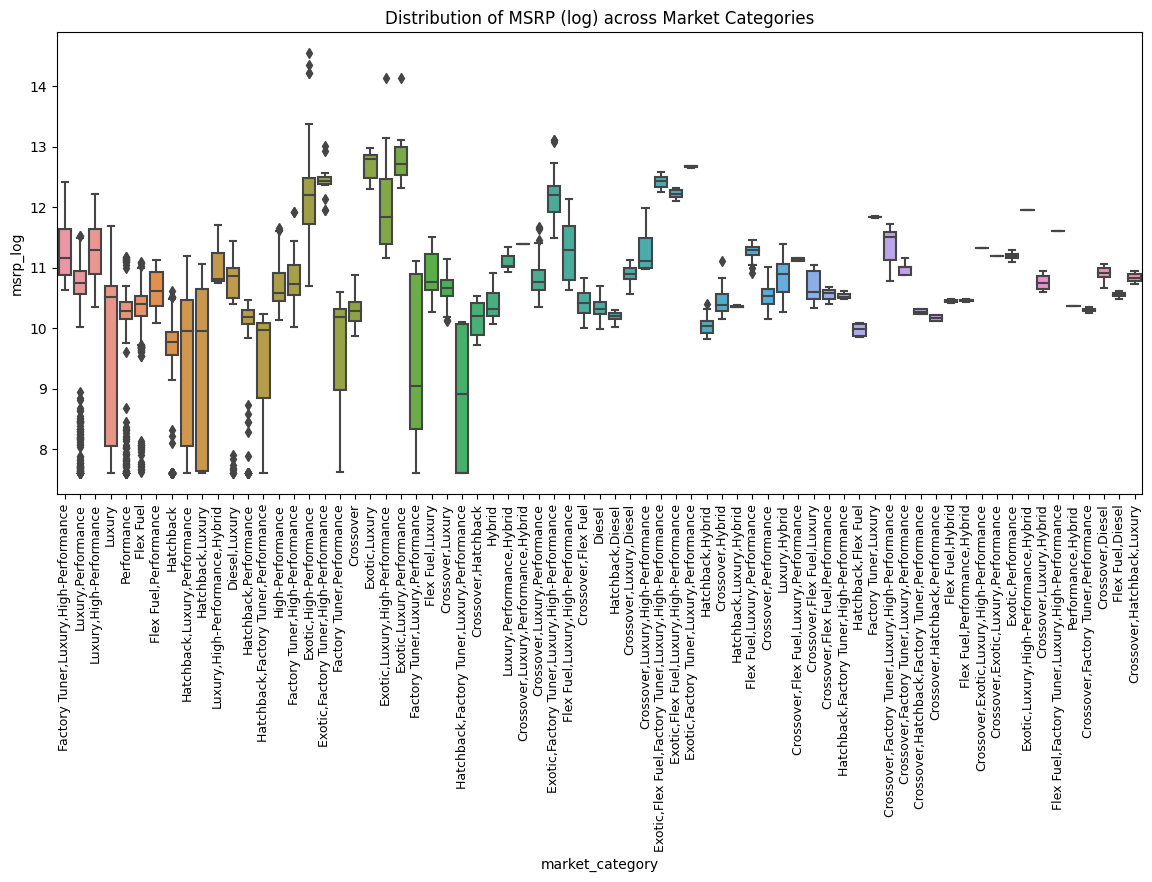

In [27]:
# Plot a distribution graph of `log_msrp' across `market_category`
plt.figure(figsize=(14, 6))
ax = sns.boxplot(data=df, x='market_category', y='msrp_log')
plt.xticks(rotation=90, fontsize=9)
plt.title("Distribution of MSRP (log) across Market Categories")
plt.show()

**Takeaways:**

- The box plots for `market_category` show considerable variation in both median and spread.
- This variation in central tendency and spread (IQR and whiskers) suggests that this multi-label category captures meaningful differences in `msrp_log` distribution.
- While overlaps exists across categories, the wide variation in median and spread suggests that each `market_category` captures a distinct pricing profile, supporting its potential predictive value.

Now that we've established that `market_category` likely holds predictive value, it might be worth investing effort into imputing its missing values. The next step is to explore potential strategies for imputation — such as using related features like `vehicle_style`.

#### **2.3.2 Validate and Clean `market_category`**

In [28]:
# See if the training set captured all unique market categories from the original table
# We want to ensure the training set has all possible market categories
print("No. of unique values in original: ", df.market_category.dropna().unique().shape[0])
print("No. of unique values in training set: ", train_df.market_category.dropna().unique().shape[0])

No. of unique values in original:  71
No. of unique values in training set:  69


In [29]:
# Find out which `market_category` values are missing in the training set
set(df.market_category) - set(train_df.market_category)

{'Crossover,Exotic,Luxury,High-Performance',
 'Flex Fuel,Factory Tuner,Luxury,High-Performance'}

In [30]:
# Count the instances of these missing values in the original dataset 

# If there are many samples with these categories, we keep them in the training set
# If few samples exist, we remove them in the other subsets (validation and test)
print("Count of first missing category: ", df[df["market_category"] == "Crossover,Exotic,Luxury,High-Performance"].shape[0])
print("Count of second missing category: ", df[df["market_category"] == "Flex Fuel,Factory Tuner,Luxury,High-Performance"].shape[0])

Count of first missing category:  1
Count of second missing category:  1


In [31]:
# Since the two labels only have one instances each, we remove them in the validation and test set
val_df = val_df[val_df["market_category"] != "Crossover,Exotic,Luxury,High-Performance"]
val_df = val_df[val_df["market_category"] != "Flex Fuel,Factory Tuner,Luxury,High-Performance"]

test_df = test_df[test_df["market_category"] != "Crossover,Exotic,Luxury,High-Performance"]
test_df = test_df[test_df["market_category"] != "Flex Fuel,Factory Tuner,Luxury,High-Performance"]

#### **2.3.3 Prove correlation between `vehicle_style` and `market_category`**

In [32]:
# Each entry contain multiple comma-separated categories (e.g., "Luxury,Performance")
# Extract all unique categories to understand the range of market segments in the data
data = df.dropna()["market_category"].apply(lambda x: x.split(","))

uniques = set()
for categories in data:
    for category in categories:
        uniques.add(category)
uniques

{'Crossover',
 'Diesel',
 'Exotic',
 'Factory Tuner',
 'Flex Fuel',
 'Hatchback',
 'High-Performance',
 'Hybrid',
 'Luxury',
 'Performance'}

In [33]:
# Check for overlaps in vehicle_style
df["vehicle_style"].unique()

array(['Coupe', 'Convertible', 'Sedan', 'Wagon', '4dr Hatchback',
       '2dr Hatchback', '4dr SUV', 'Passenger Minivan', 'Cargo Minivan',
       'Crew Cab Pickup', 'Regular Cab Pickup', 'Extended Cab Pickup',
       '2dr SUV', 'Cargo Van', 'Convertible SUV', 'Passenger Van'],
      dtype=object)

In [34]:
# Create table with non-null `market_category` for later analysis
market_cat_nn = train_df[train_df["market_category"].notna()]

# Store the counts of each market category combination per vehicle style 
cat_count_per_style = train_df.groupby(["vehicle_style", "market_category"])["market_category"].count().reset_index(name="frequency")

# Resulting table will be used in our correlation test
cat_count_per_style  

,vehicle_style,market_category,frequency
0,2dr Hatchback,Hatchback,198
1,2dr Hatchback,"Hatchback,Diesel",7
2,2dr Hatchback,"Hatchback,Factory Tuner,Luxury,Performance",4
3,2dr Hatchback,"Hatchback,Factory Tuner,Performance",10
4,2dr Hatchback,"Hatchback,Hybrid",15
...,...,...,...
169,Wagon,Hybrid,15
170,Wagon,Luxury,77
171,Wagon,"Luxury,High-Performance",3
172,Wagon,"Luxury,Performance",29


**Note:** One way to prove if there's a meaningful relationship between `vehicle_style` and `market_category` is to use a stacked bar chart and see how `market_category` values are distributed within each `vehicle_style`. Clear patterns may indicate a meaningful relationship.

In [35]:
# See the distribution of market categories per vehicle style
fig12 = px.bar(cat_count_per_style,
             x="vehicle_style",
             y="frequency",
             color="market_category",
             height=700)

fig12.update_layout(title='Market Category by Vehicle Style')

fig12.show(renderer='iframe')

**Takeaways:**

1. We can see certain market category combinations dominate each vehicle style.
2. The market categories correlate with specific styles (e.g., 'Flex Fuel' for vans, 'Hatchback' for hatches, 'High-Performance' for sportscars).
3. Distribution of market category combinations per style is clearly not uniform.

In [36]:
# See if we still get unique market category permutations if we don't consider order
print("No. of unique market category combinations (not considering order):", market_cat_nn["market_category"].apply(lambda x: ",".join(sorted(x.split(",")))).unique().shape[0])
print("No. of unique market category permutations (considering order):", market_cat_nn["market_category"].unique().shape[0])
print("\t")
print("We can conclude each unique market category is actually unique rather than being just a reorder of another.")

No. of unique market category combinations (not considering order): 69
No. of unique market category permutations (considering order): 69
	
We can conclude each unique market category is actually unique rather than being just a reorder of another.


**Note:** We use **chi-square tests** to determine if there is a strong relationship between the two features.

In [37]:
# Create a two-way table between the two features
contingency_table = pd.crosstab(train_df['market_category'], train_df['vehicle_style'])

# Calculate the Chi-Square statistic and p-value between `market_category` and `vehicle_style`
chi_square_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic (𝜒2): {chi_square_stat:.4f}, p-value: {p_value}, degree of freedom: {dof}")

# Get the critical value for the degree of freedom and significance level
alpha = 0.05 # Set the significance level
critical_value = chi2.ppf(1 - alpha, dof) # Calculate the critical value
print(f"The critical value for the dof is {critical_value:.4f} and the significance level is {alpha}")

Chi-Square Statistic (𝜒2): 18214.8046, p-value: 0.0, degree of freedom: 1020
The critical value for the dof is 1095.4116 and the significance level is 0.05


**Takeways:**

1. A larger Chi-Square statistic generally means a stronger relationship or association between the variables.
2. A p-value close to 0 means there’s an extremely low probability that the observed differences between the variables occurred due to random chance.
3. The p-value is less than the significance level (𝛼), thus we reject the null hypothesis (𝐻0).
4. 𝜒2 is greater than the critical value, we reject 𝐻0.
5. Since the p-value (approx. 0.0) is less than 0.05, we reject the independence assumption.

#### **2.3.4 Attempt to Find Missing `market_category` based on `vehicle_style`**

For each `vehicle_style` category, the aim is to use the most frequently occurring market category to fill in any missing values. 

However, we need to examine first if the frequently-occurring category seen in the dataset is indeed reflective of real-world trends.

In [38]:
# The table we created earlier storing the counts of each market category within each vehicle style
cat_count_per_style

,vehicle_style,market_category,frequency
0,2dr Hatchback,Hatchback,198
1,2dr Hatchback,"Hatchback,Diesel",7
2,2dr Hatchback,"Hatchback,Factory Tuner,Luxury,Performance",4
3,2dr Hatchback,"Hatchback,Factory Tuner,Performance",10
4,2dr Hatchback,"Hatchback,Hybrid",15
...,...,...,...
169,Wagon,Hybrid,15
170,Wagon,Luxury,77
171,Wagon,"Luxury,High-Performance",3
172,Wagon,"Luxury,Performance",29


In [39]:
# Capture the market category with the highest frequency (mode) for each vehicle style
highest_freq = cat_count_per_style.loc[cat_count_per_style.groupby("vehicle_style")["frequency"].idxmax()].reset_index(drop=True)
highest_freq

,vehicle_style,market_category,frequency
0,2dr Hatchback,Hatchback,198
1,2dr SUV,"Crossover,Luxury",7
2,4dr Hatchback,Hatchback,260
3,4dr SUV,Crossover,701
4,Cargo Minivan,Flex Fuel,1
5,Cargo Van,Flex Fuel,26
6,Convertible,Performance,96
7,Convertible SUV,Crossover,3
8,Coupe,"Exotic,High-Performance",125
9,Crew Cab Pickup,Flex Fuel,154


Here's a quick validation of whether the `market_category` mode per `vehicle_style` reflects real-world automotive trends:

| vehicle_style       | market_category         | Real-World Fit? | Notes                                                                                   |
|---------------------|-------------------------|----------------|-----------------------------------------------------------------------------------------|
| 2dr Hatchback       | Hatchback               | ✅             | Expected match.                                                                         |
| 2dr SUV             | Crossover, Luxury       | ⚠️             | 2dr SUVs are rare. "Luxury" may apply to niche models, but not always Crossover.        |
| 4dr Hatchback       | Hatchback               | ✅             | Matches standard category.                                                              |
| 4dr SUV             | Crossover               | ✅             | Most modern 4dr SUVs are crossovers.                                                   |
| Cargo Minivan       | Flex Fuel               | ⚠️             | Possible but rare. Flex Fuel isn't really a market category.                            |
| Cargo Van           | Flex Fuel               | ⚠️             | Same as above.                                              |
| Convertible         | Performance             | ✅             | Most convertibles are sold for performance/luxury appeal.                              |
| Convertible SUV     | Crossover               | ⚠️             | Crossovers in convertible form are extremely niche (e.g., Nissan Murano CrossCabriolet). |
| Coupe               | Exotic, High-Performance| ✅             | Matches high-end sports and luxury coupes.                                            |
| Crew Cab Pickup     | Flex Fuel               | ✅             | Common in U.S. market. many pickups are Flex Fuel compatible.                          |
| Extended Cab Pickup | Flex Fuel               | ✅             | Same as above.                                                                         |
| Passenger Minivan   | Flex Fuel               | ⚠️             | Technically possible.    |
| Passenger Van       | Flex Fuel               | ⚠️             | Technically possible.                          |
| Regular Cab Pickup  | Flex Fuel               | ✅             | Consistent with U.S. market vehicles.                                                 |
| Sedan               | Luxury                  | ⚠️             | Not all sedans are luxury. this could be skewed by brand distribution.                 |
| Wagon               | Luxury                  | ⚠️             | Many wagons are family or utility focused, unless skewed by high-end brands (e.g., Audi, Volvo). |

In [40]:
# Impute the missing market categories where the mode based on vehicle_style make sense
for style in ["2dr Hatchback", "4dr Hatchback", "4dr SUV", "Convertible", "Coupe", "Crew Cab Pickup", "Extended Cab Pickup", "Regular Cab Pickup"]:
    category = highest_freq.loc[highest_freq["vehicle_style"] == style, "market_category"].values[0]
    train_df.loc[(train_df["vehicle_style"] == style) & (train_df["market_category"].isna()), "market_category"] = category
    val_df.loc[(val_df["vehicle_style"] == style) & (val_df["market_category"].isna()), "market_category"] = category
    test_df.loc[(test_df["vehicle_style"] == style) & (test_df["market_category"].isna()), "market_category"] = category

##### **2.3.4.1 Figure Out How to Fill Missing Data for 2dr SUV**

2dr SUV having the mode category "Crossover,Luxury" likely does not reflect actual trends.

In [41]:
# See what other market categories are available for '2dr SUV' and if we can use one for imputation
train_df[(train_df["vehicle_style"] == "2dr SUV") & (train_df["market_category"].notna())]["market_category"].unique()

array(['Crossover,Luxury', 'Luxury', 'Factory Tuner,Performance'],
      dtype=object)

In [42]:
# Check how many '2dr SUV' records exist and how many of these have missing `market_category` values
num_2dr = train_df.query("vehicle_style == '2dr SUV'").shape[0]
print("No. of records for 2dr SUV:", num_2dr)
print("No. of records with missing val:", num_2dr-train_df[(train_df["vehicle_style"] == "2dr SUV") & (train_df["market_category"].notna())].shape[0])

No. of records for 2dr SUV: 97
No. of records with missing val: 86


**Takeaways:**

The other two available categories are also not well-suited for 2dr SUVs. We currently do not have a strong mode to impute from.
- The number of non-missing samples is very small 
- The known categories are inconsistent with 2dr SUVs in general
- There's not enough reliable information to confidently impute a value.

We leave these values as `Unknown` to avoid making unsupported assumptions. 

##### **2.3.4.2 Figure out how to fill missing data for Cargo Minivan**

`Flex Fuel` as `market_category` cannot generalize to all cargo minivans to so we need to consider a more accurate category.

In [43]:
# See what other market categories are available
train_df[(train_df["vehicle_style"] == "Cargo Minivan") & (train_df["market_category"].notna())]["market_category"].value_counts()

market_category
Flex Fuel    1
Name: count, dtype: int64

In [44]:
num_cargo_mv = train_df.query("vehicle_style == 'Cargo Minivan'").shape[0]
print("No. of records for Cargo Minivan:", num_cargo_mv)
print("No. of records with missing val:", num_cargo_mv-train_df[(train_df["vehicle_style"] == "Cargo Minivan") & (train_df["market_category"].notna())].shape[0])

No. of records for Cargo Minivan: 46
No. of records with missing val: 45


**Takeaways:**

- A large number of records has missing market_category values.
- The one category in the training set 'Flex Fuel' is not representative of typical cargo minivans.
- To avoid forcing inaccurate imputations, we leave these missing values as `Unknown`.

##### **2.3.4.3 Cargo Van**

Similar to cargo vans, `Flex Fuel` as a `market_category` is not representative of typical cargo vans. We need to consider a more accurate category 

In [45]:
# See what other market categories are available
train_df[(train_df["vehicle_style"] == "Cargo Van") & (train_df["market_category"].notna())]["market_category"].value_counts()

market_category
Flex Fuel    26
Name: count, dtype: int64

In [46]:
num_cargo_van = train_df.query("vehicle_style == 'Cargo Van'").shape[0]
print("No. of records for Cargo Van:", num_cargo_van)
print("No. of records with missing val:", num_cargo_van-train_df[(train_df["vehicle_style"] == "Cargo Van") & (train_df["market_category"].notna())].shape[0])

No. of records for Cargo Van: 70
No. of records with missing val: 44


**Takeaway:** Because the missing proportion is high and Flex Fuel don’t strongly represent this vehicle style, it might be best to leave these as `Unknown` as well for now to avoid inaccurate imputations.

##### **2.3.4.4 Convertible SUV**

Many convertible SUVs do not use a crossover frame so we cannot directly impute the `vehicle_style` mode `Crossover`

In [47]:
# See what other market categories are available
train_df[(train_df["vehicle_style"] == "Convertible SUV") & (train_df["market_category"].notna())]["market_category"].value_counts()

market_category
Crossover    3
Luxury       1
Name: count, dtype: int64

In [48]:
num_conv_suv = train_df.query("vehicle_style == 'Convertible SUV'").shape[0]
print("No. of records for Convertible SUV:", num_conv_suv)
print("No. of records with missing val:", num_conv_suv-train_df[(train_df["vehicle_style"] == "Convertible SUV") & (train_df["market_category"].notna())].shape[0])

No. of records for Convertible SUV: 25
No. of records with missing val: 21


**Takeaways:** Since `Convertible SUV` and `Crossover` are highly related, it might be reasonable to impute missing values as `Crossover` or `Crossover,Luxury`. However, doing so would be too much of a generalization since many SUV models are not crossovers. The absence of a `market_category` label may actually reflect this ambiguity, suggesting that a default imputation could misrepresent the vehicle's true market positioning. For this reason, this will included in the `Unknown` category.

##### **2.3.4.5 Passenger Minivan and Van**

Flex Fuel is common in passenger vans and minivans. Still, it may be worth looking at other alternatives.

In [49]:
# See what other market categories are available for both style
print("Pass. Minivan:")
print(train_df[(train_df["vehicle_style"] == "Passenger Minivan") & (train_df["market_category"].notna())]["market_category"].value_counts())
print()
print("Pass. Van:")
print(train_df[(train_df["vehicle_style"] == "Passenger Van") & (train_df["market_category"].notna())]["market_category"].value_counts())

Pass. Minivan:
market_category
Flex Fuel      46
Performance     1
Luxury          1
Name: count, dtype: int64

Pass. Van:
market_category
Flex Fuel           47
Flex Fuel,Diesel    13
Diesel              10
Name: count, dtype: int64


In [50]:
# Check how many records exist and how many of these have missing market_category values
num_pm = train_df.query("vehicle_style == 'Passenger Minivan'").shape[0]
print("No. of records for Passenger Minivan:", num_pm)
print("No. of records with missing val:", num_pm-train_df[(train_df["vehicle_style"] == "Passenger Minivan") & (train_df["market_category"].notna())].shape[0])

num_van = train_df.query("vehicle_style == 'Passenger Van'").shape[0]
print("No. of records for Passenger Van:", num_van)
print("No. of records with missing val:", num_van-train_df[(train_df["vehicle_style"] == "Passenger Van") & (train_df["market_category"].notna())].shape[0])

No. of records for Passenger Minivan: 283
No. of records with missing val: 235
No. of records for Passenger Van: 89
No. of records with missing val: 19


**Takeaway:** Looking at the other available categories, imputing `Flex Fuel` makes the most sense since a significant number of vans and minivans use Flex Fuel.

In [51]:
# Fill the missing values for 'Van' and 'Passenger Minivan' with 'Flex Fuel'
train_df.loc[((train_df["vehicle_style"].isin(["Van", "Passenger Minivan"])) & (train_df["market_category"].isnull())), "market_category"] = "Flex Fuel"

##### **2.3.4.6 Sedan**

The market categories for this style varies a lot. This is because sedans cater to a wide range of segments, from affordable compact models to high-end luxury and performance vehicles

In [52]:
# See what other market categories are available for Sedan
train_df[(train_df["vehicle_style"] == "Sedan") & (train_df["market_category"].notna())]["market_category"].value_counts().sample(10)

market_category
Performance                              199
Flex Fuel,Luxury,High-Performance          7
Luxury,Performance,Hybrid                  9
Flex Fuel,Luxury                           8
Diesel                                     8
Luxury,Hybrid                             18
Luxury                                   351
Factory Tuner,Luxury,High-Performance     77
High-Performance                          14
Exotic,Performance                         8
Name: count, dtype: int64

In [53]:
num_sedan = train_df.query("vehicle_style == 'Sedan'").shape[0]
print("No. of records for Sedan:", num_sedan)
print("No. of records with missing val:", num_sedan-train_df[(train_df["vehicle_style"] == "Sedan") & (train_df["market_category"].notna())].shape[0])

No. of records for Sedan: 2176
No. of records with missing val: 771


**Takeaway:** `Luxury` is the most frequent and it fits both mid-range and high-end sedans but it may overlook other aspects of sedans. We can impute this category as the default after filtering based on horsepower, no. of cylinder and msrp range.

In [54]:
# Low HP and cylinders is labeled "Unknown"
train_df.loc[(train_df['vehicle_style'] == 'Sedan') & (train_df['market_category'].isnull()) & (train_df['engine_hp'] < 130) & (train_df['engine_cylinders'] <= 4) & (train_df['msrp_log'] < 8), 'market_category'] = "Unknown"
val_df.loc[(val_df['vehicle_style'] == 'Sedan') & (val_df['market_category'].isnull()) & (val_df['engine_hp'] < 130) & (val_df['engine_cylinders'] <= 4) & (val_df['msrp_log'] < 8), 'market_category'] = "Unknown"
test_df.loc[(test_df['vehicle_style'] == 'Sedan') & (test_df['market_category'].isnull()) & (test_df['engine_hp'] < 130) & (test_df['engine_cylinders'] <= 4) & (test_df['msrp_log'] < 8), 'market_category'] = "Unknown"

# Higher HP or more cylinders with high MSRP is "Luxury,Performance"
train_df.loc[(df['vehicle_style'] == 'Sedan') & (train_df['market_category'].isnull()) & (train_df['engine_hp'] >= 200) & (train_df['engine_cylinders'] >= 6) & (train_df['msrp_log'] > 7), 'market_category'] = 'Luxury,Performance'
val_df.loc[(df['vehicle_style'] == 'Sedan') & (val_df['market_category'].isnull()) & (val_df['engine_hp'] >= 200) & (val_df['engine_cylinders'] >= 6) & (val_df['msrp_log'] > 7), 'market_category'] = 'Luxury,Performance'
test_df.loc[(df['vehicle_style'] == 'Sedan') & (test_df['market_category'].isnull()) & (test_df['engine_hp'] >= 200) & (test_df['engine_cylinders'] >= 6) & (test_df['msrp_log'] > 7), 'market_category'] = 'Luxury,Performance'

# Fall back to the most common value "Luxury"
train_df.loc[(df['vehicle_style'] == 'Sedan') & (train_df['market_category'].isnull()), 'market_category'] = 'Luxury'
val_df.loc[(df['vehicle_style'] == 'Sedan') & (val_df['market_category'].isnull()), 'market_category'] = 'Luxury'
test_df.loc[(df['vehicle_style'] == 'Sedan') & (test_df['market_category'].isnull()), 'market_category'] = 'Luxury'

**2.3.4.7 Wagon**

In [55]:
num_wagon = df.query("vehicle_style == 'Wagon'").shape[0]
print("No. of records for Wagon:", num_wagon)
print("No. of records with missing val:", num_wagon-df[(df["vehicle_style"] == "Wagon") & (df["market_category"].notna())].shape[0])

No. of records for Wagon: 592
No. of records with missing val: 235


In [56]:
# See what other market categories are available
df[(df["vehicle_style"] == "Wagon") & (df["market_category"].notna())]["market_category"].value_counts().sample(10)

market_category
Factory Tuner,High-Performance             3
Flex Fuel                                 11
Factory Tuner,Luxury,High-Performance      6
Crossover,Luxury,Performance              11
Crossover                                 66
Luxury                                   104
Crossover,Luxury,Diesel                    3
Crossover,Performance                     24
Luxury,Performance                        39
Hybrid                                    18
Name: count, dtype: int64

**Takeaway:** `Luxury` is reasonable for Wagon type vehicles. We can try imputing the same way we did with Sedans.

In [57]:
# Low HP and cylinders, low MSRP likely non-luxury/crossover
train_df.loc[(train_df['vehicle_style'] == 'Wagon') & (train_df['market_category'].isnull()) & (train_df['engine_hp'] < 150) & (train_df['engine_cylinders'] <= 4) & (train_df['msrp_log'] < 8), 'market_category'] = "Crossover"
val_df.loc[(val_df['vehicle_style'] == 'Wagon') & (val_df['market_category'].isnull()) & (val_df['engine_hp'] < 150) & (val_df['engine_cylinders'] <= 4) & (val_df['msrp_log'] < 8), 'market_category'] = "Crossover"
test_df.loc[(test_df['vehicle_style'] == 'Wagon') & (test_df['market_category'].isnull()) & (test_df['engine_hp'] < 150) & (test_df['engine_cylinders'] <= 4) & (test_df['msrp_log'] < 8), 'market_category'] = "Crossover"

# Higher HP and MSRP likely "Luxury,Performance"
train_df.loc[(train_df['vehicle_style'] == 'Wagon') & (train_df['market_category'].isnull()) & (train_df['engine_hp'] >= 180) & (train_df['engine_cylinders'] > 4) & (train_df['msrp_log'] > 8), 'market_category'] = "Luxury,Performance"
val_df.loc[(val_df['vehicle_style'] == 'Wagon') & (val_df['market_category'].isnull()) & (val_df['engine_hp'] >= 180) & (val_df['engine_cylinders'] >= 4) & (val_df['msrp_log'] > 8), 'market_category'] = "Luxury,Performance"
test_df.loc[(test_df['vehicle_style'] == 'Wagon') & (test_df['market_category'].isnull()) & (test_df['engine_hp'] >= 180) & (test_df['engine_cylinders'] >= 4) & (test_df['msrp_log'] > 8), 'market_category'] = "Luxury,Performance"

# For the remaining missing values
train_df.loc[(train_df['vehicle_style'] == 'Wagon') & (train_df['market_category'].isnull()), 'market_category'] = "Crossover,Luxury"
val_df.loc[(val_df['vehicle_style'] == 'Wagon') & (val_df['market_category'].isnull()), 'market_category'] = "Crossover,Luxury"
test_df.loc[(test_df['vehicle_style'] == 'Wagon') & (test_df['market_category'].isnull()), 'market_category'] = "Crossover,Luxury"

In [58]:
# Fill in values with "Unknown" category
train_df['market_category'].fillna('Unknown', inplace=True)
val_df['market_category'].fillna('Unknown', inplace=True)
test_df['market_category'].fillna('Unknown', inplace=True)

### **2.5 Encode Categorical Variables**

We want to determine a suitable encoding method for each of these categorical features based on their cardinality and relationship to the target variable.

In [59]:
# List categorical variables and number of unique categories
cat_cols = train_df.select_dtypes(include="object").columns  # or "category" if applicable
df[cat_cols].nunique().sort_values(ascending=False)

model                916
market_category       71
make                  48
vehicle_style         16
engine_fuel_type      10
transmission_type      5
driven_wheels          4
vehicle_size           3
dtype: int64

#### **2.5.1 Encode `make`**

In [60]:
make_counts = train_df["make"].value_counts()
make_counts

make
Chevrolet        812
Ford             621
Volkswagen       568
Toyota           517
Dodge            447
Nissan           379
GMC              333
Honda            309
Mazda            286
Cadillac         282
Suzuki           256
Mercedes-Benz    250
Audi             240
Infiniti         232
BMW              230
Hyundai          219
Volvo            211
Acura            173
Subaru           165
Kia              164
Mitsubishi       159
Lexus            139
Buick            129
Chrysler         128
Pontiac          122
Lincoln          120
Oldsmobile       106
Land Rover        90
Porsche           87
Saab              83
Aston Martin      67
Bentley           57
Plymouth          55
Ferrari           51
Scion             42
Lamborghini       39
FIAT              38
Maserati          35
Rolls-Royce       24
Lotus             24
Tesla             14
Maybach           10
HUMMER            10
Alfa Romeo         4
Spyker             3
McLaren            3
Bugatti            3
Genesis 

**Takeaway:** `make` has a clear frequency imbalance. We can keep the ordinal relationship of car brand popularity with **frequency encoding**.

In [61]:
# Frequency encode make
train_df['make_enc'] = train_df['make'].map(make_counts)
val_df['make_enc'] = val_df['make'].map(make_counts)
test_df['make_enc'] = test_df['make'].map(make_counts)

In [62]:
# Confirm relationship to target `msrp_log`
print(train_df['make_enc'].corr(train_df["msrp_log"]))
print(train_df['make_enc'].corr(train_df["msrp"]))

-0.15465299883328357
-0.23928754804436142


#### **2.5.2 Encode `model`**

`model` is a direct predictor of price (a Reventon will always have significantly higher msrp than a Civic or Contour). This makes **target encoding** particularly appropriate.

In [63]:
msrp_mean_by_model = train_df.groupby("model")["msrp_log"].mean()

train_df["model_enc"] = train_df["model"].map(msrp_mean_by_model)
val_df["model_enc"] = val_df["model"].map(msrp_mean_by_model)
test_df["model_enc"] = test_df["model"].map(msrp_mean_by_model)

In [64]:
global_mean = train_df["msrp_log"].mean()

val_df["model_enc"].fillna(global_mean, inplace=True)
test_df["model_enc"].fillna(global_mean, inplace=True)

#### **2.5.3 Encode `market_category`**

`market_category` is a multi-label, high-cardinality feature that can best be handled with target encoding. We encode each category with the mean of the target variable `msrp_log` for that category. This directly reflects how the category correlates with pricing, exactly what we care about in a regression task.

In [65]:
mcat_counts = train_df["market_category"].value_counts()
mcat_counts

market_category
Flex Fuel                              1536
Crossover                              1053
Luxury                                  903
Unknown                                 700
Luxury,Performance                      537
                                       ... 
Crossover,Exotic,Luxury,Performance       1
Factory Tuner,Luxury                      1
Performance,Hybrid                        1
Flex Fuel,Hybrid                          1
Flex Fuel,Performance,Hybrid              1
Name: count, Length: 70, dtype: int64

In [66]:
msrp_mean_by_mcat = train_df.groupby("market_category")["msrp_log"].mean()

# Apply smoothing to reduce overfitting by preventing few sample categories from overly influencing target
global_mean = train_df["msrp_log"].mean()
alpha = 10
market_cat_enc = ((mcat_counts * msrp_mean_by_mcat + alpha * global_mean) / (mcat_counts + alpha)).to_dict()

In [67]:
# Apply to all subsets
train_df["market_category_enc"] = train_df["market_category"].map(market_cat_enc)
val_df["market_category_enc"] = val_df["market_category"].map(market_cat_enc)
test_df["market_category_enc"] = test_df["market_category"].map(market_cat_enc)

#### **2.5.4 One-Hot Encode the Remaining Categorical Columns**

For categorical features with low cardinality, one-hot encoding is simple and effective.

In [68]:
cols = ["vehicle_style", "engine_fuel_type", "transmission_type", "driven_wheels", "vehicle_size"]

# One-hot encode the remaining categorical columns
train_df = pd.get_dummies(train_df, columns=cols)
val_df = pd.get_dummies(val_df, columns=cols)
test_df = pd.get_dummies(test_df, columns=cols)

# Convert bool values to int
for subset in [train_df, val_df, test_df]:
    for col in subset.select_dtypes(include="bool").columns:
        subset[col] = subset[col].astype(float)

# Match validation and test set columns to train set
val_df = val_df.reindex(columns=train_df.columns, fill_value=0.0)
test_df = test_df.reindex(columns=train_df.columns, fill_value=0.0)

### **2.6 Scale Features Into a Similar Range**  

In [69]:
# Extract the numerical columns
train_df_nums = train_df.select_dtypes(include="number").iloc[:, :13]
num_cols = train_df_nums.columns
num_cols  # Display the column names

Index(['year', 'engine_hp', 'engine_cylinders', 'number_of_doors',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp', 'msrp_log',
       'market_category_missing', 'make_enc', 'model_enc',
       'market_category_enc'],
      dtype='object')

In [70]:
# Z-score normalize the numerical columns
scaler = StandardScaler()
train_df_nums_scaled = pd.DataFrame(scaler.fit_transform(train_df_nums), columns=num_cols)

In [71]:
# Apply the same scaling to the validation and test sets
# Note that we only use the training set's fitted scaler parameters to prevent data leakage
val_df_nums_scaled = pd.DataFrame(scaler.transform(val_df[num_cols]), columns=num_cols)
test_df_nums_scaled = pd.DataFrame(scaler.transform(test_df[num_cols]), columns=num_cols)

# Drop the non-scaled numerical columns on all subsets (replaced later w/ their scaled versions) 
# This leaves the non-numerical and one-hot encoded columns
train_temp = train_df.drop(columns=num_cols)
val_temp = val_df.drop(columns=num_cols)
test_temp = test_df.drop(columns=num_cols)

# Remove non-numeric columns (which we've already encoded), leaving only the one-hot enc columns
# Later, we will merge this one-hot enc columns with the scaled numerical tables we created
train_oh = train_temp.select_dtypes(include="number")
val_oh = val_temp.select_dtypes(include="number")
test_oh = test_temp.select_dtypes(include="number")

In [72]:
# Merge the scaled numerical features with the one-hot encoded features
# The resulting tables will contain all the features we require for model fitting (after removing 'msrp' and 'market_category_missing' which we don't need)
train_set = pd.concat([train_df_nums_scaled.reset_index(drop=True), train_oh.reset_index(drop=True)], axis=1)
val_set = pd.concat([val_df_nums_scaled.reset_index(drop=True), val_oh.reset_index(drop=True)], axis=1)
test_set = pd.concat([test_df_nums_scaled.reset_index(drop=True), test_oh.reset_index(drop=True)], axis=1)

# Remove `msrp` and `market_category_missing` columns
train_set.drop(columns=["market_category_missing", "msrp"], inplace=True)
val_set.drop(columns=["market_category_missing", "msrp"], inplace=True)
test_set.drop(columns=["market_category_missing", "msrp"], inplace=True)

## **3. Model Fitting**

In [73]:
# Split inputs and output for all subsets
X_train, y_train = train_set.drop(columns=["msrp_log"]), train_set["msrp_log"]
X_val, y_val = val_set.drop(columns=["msrp_log"]), val_set["msrp_log"]
X_test, y_test = test_set.drop(columns=["msrp_log"]), test_set["msrp_log"]

### **3.1 Linear, Ridge, and Lasso Regression**

In [74]:
# Define the models in a dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.01),
    "Ridge Regression": Ridge(alpha=1.0)
    
}

model_scores = []

# Loop through each model
for name, model in models.items():
    model.fit(X_train, y_train)

    # Predict on train set
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)

    # Predict on test set
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    model_scores.append([f"{name}", f"{mse_train:.7f}", f"{mse_train:.7f}", f"{mse_val:.7f}", f"{r2_val:.7f}", f"{mse_test:.7f}", f"{r2_test:.7f}"])

model_scores = pd.DataFrame(model_scores)
model_scores.columns = ["model", "train_mse", "train_r2", "val_mse", "val_r2", "test_mse", "test_r2"]
model_scores

,model,train_mse,train_r2,val_mse,val_r2,test_mse,test_r2
0,Linear Regression,0.0360108,0.0360108,0.0584938,0.9391742,0.0662071,0.9357432
1,Lasso Regression,0.0384062,0.0384062,0.0619697,0.9355598,0.0701307,0.9319351
2,Ridge Regression,0.0360118,0.0360118,0.0585057,0.9391619,0.0661924,0.9357575


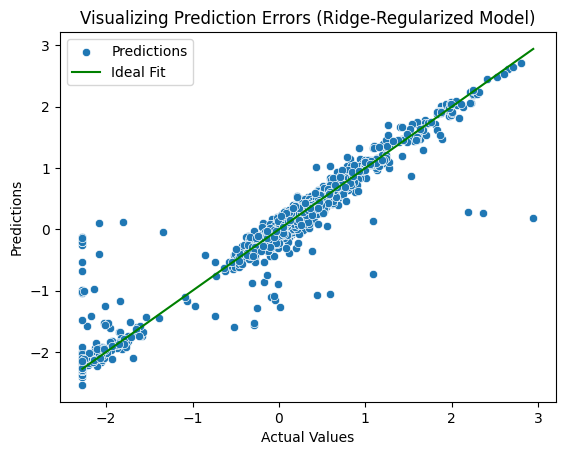

In [75]:
plt.figure()
sns.scatterplot(x=y_test, y=y_test_pred, label="Predictions")
sns.lineplot(x=y_test, y=y_test, color="g", label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Visualizing Prediction Errors (Ridge-Regularized Model)")
plt.show()

### **3.2 Polynomial Regression (L2 Regularized)**

In [76]:
deg_scores = []

for deg in range(2, 4):
    poly = PolynomialFeatures(degree=deg)
    Xtrain_poly = poly.fit_transform(X_train)
    lin_reg = Ridge().fit(Xtrain_poly, y_train)

    # train predictions
    train_preds = lin_reg.predict(Xtrain_poly)
    train_mse = mean_squared_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)

    # validation predictions 
    Xval_poly = poly.fit_transform(X_val)
    val_preds = lin_reg.predict(Xval_poly)
    val_mse = mean_squared_error(y_val, val_preds)
    val_r2 = r2_score(y_val, val_preds)

    # Test predictions
    Xtest_poly = poly.fit_transform(X_test)
    test_preds = lin_reg.predict(Xtest_poly)
    test_mse = mean_squared_error(y_test, test_preds)
    test_r2 = r2_score(y_test, test_preds)

    deg_scores.append([f"Polynomial Degree {deg}", f"{train_mse:.7f}", f"{train_r2:.7f}", f"{val_mse:.7f}", f"{val_r2:.7f}", f"{test_mse:.7f}", f"{test_r2:.7f}"])

deg_scores = pd.DataFrame(deg_scores)
deg_scores.columns = ["model", "train_mse", "train_r2", "val_mse", "val_r2", "test_mse", "test_r2"]
deg_scores

,model,train_mse,train_r2,val_mse,val_r2,test_mse,test_r2
0,Polynomial Degree 2,0.0271866,0.9728134,0.0426893,0.9556088,0.0512136,0.9502950
1,Polynomial Degree 3,0.0145400,0.9854600,0.0352592,0.9633351,0.0325120,0.9684457


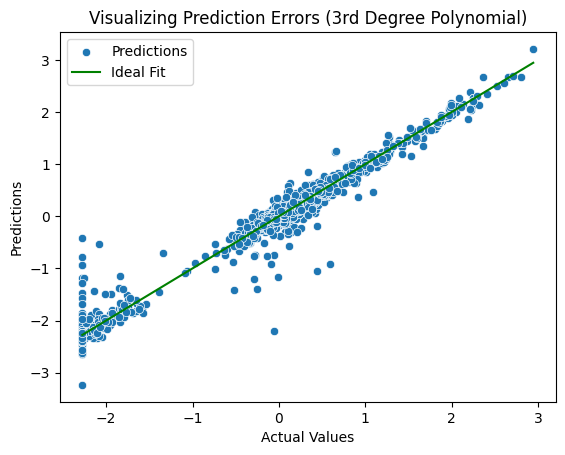

In [77]:
plt.figure()
sns.scatterplot(x=y_test, y=test_preds, label="Predictions")
sns.lineplot(x=y_test, y=y_test, color="g", label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Visualizing Prediction Errors (3rd Degree Polynomial)")
plt.show()

### **3.3 Decision Tree Regression**

In [78]:
from sklearn.tree import DecisionTreeRegressor
dtr_model = DecisionTreeRegressor(random_state=42)
dtr_model.fit(X_train, y_train)

# Prediction on train set
train_preds = dtr_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)

# Validation predictions
val_preds = dtr_model.predict(X_val)
val_mse = mean_squared_error(y_val,val_preds)
val_r2 = r2_score(y_val, val_preds)

# Test predictions
test_preds = dtr_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)
 
dtr_score = pd.DataFrame(np.array(["Decision Tree Regression", f"{val_mse:.7f}", f"{val_mse:.7f}", f"{val_mse:.7f}", f"{val_r2:.7f}", f"{test_mse:.7f}", f"{test_r2:.7f}"]).reshape(1,-1), 
                         columns=["model", "train_mse", "train_r2", "val_mse", "val_r2", "test_mse", "test_r2"])
dtr_score

,model,train_mse,train_r2,val_mse,val_r2,test_mse,test_r2
0,Decision Tree Regression,0.0148339,0.0148339,0.0148339,0.9845747,0.0198705,0.9807148


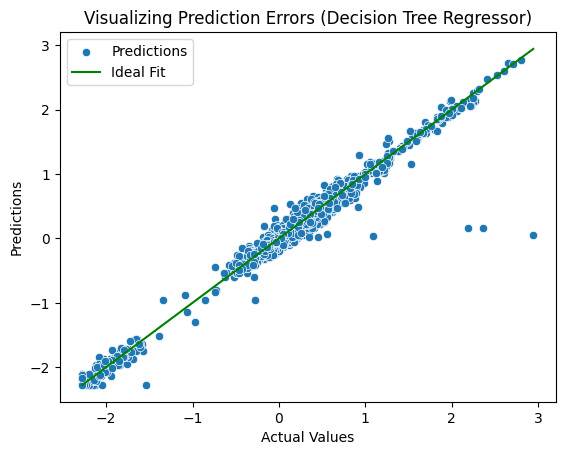

In [79]:
plt.figure()
sns.scatterplot(x=y_test, y=test_preds, label="Predictions")
sns.lineplot(x=y_test, y=y_test, color="g", label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Visualizing Prediction Errors (Decision Tree Regressor)")
plt.show()

### **3.4 Compare Model Performance**

In [80]:
performance_comp = pd.concat([model_scores, deg_scores, dtr_score], axis=0)
performance_comp

,model,train_mse,train_r2,val_mse,val_r2,test_mse,test_r2
0,Linear Regression,0.0360108,0.0360108,0.0584938,0.9391742,0.0662071,0.9357432
1,Lasso Regression,0.0384062,0.0384062,0.0619697,0.9355598,0.0701307,0.9319351
2,Ridge Regression,0.0360118,0.0360118,0.0585057,0.9391619,0.0661924,0.9357575
0,Polynomial Degree 2,0.0271866,0.9728134,0.0426893,0.9556088,0.0512136,0.9502950
1,Polynomial Degree 3,0.0145400,0.9854600,0.0352592,0.9633351,0.0325120,0.9684457
0,Decision Tree Regression,0.0148339,0.0148339,0.0148339,0.9845747,0.0198705,0.9807148
